In [3]:
import os

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
import shapely
import IPython.display as disp

import pyproj
from shapely.ops import transform
import fiona
import rasterio
import rasterio.mask
from rasterio import warp
from rasterio import windows
from rasterio import features
from rasterio.crs import CRS

from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

%matplotlib inline

# Microsoft Planetary Computer API

In [5]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

pc.settings.set_subscription_key('ff3d7cf83cf94e639742bbc89e59bcdf')

In [6]:
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [7]:
d = {
    "name": "Bhadra Reservoir",
    "longitude": 75.59,
    "latitude": 13.63,
    "date": "2021-04-30",
}
example_row = pd.Series(data=d, index=list(d.keys()))

In [8]:
example_row

name         Bhadra Reservoir
longitude               75.59
latitude                13.63
date               2021-04-30
dtype: object

In [9]:
import geopy.distance as distance

In [10]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=1e5)
print(bbox)
print("Width: ", bbox[2] - bbox[0], " Length: ", bbox[3] - bbox[1])

[74.66582930131835, 12.726102641166461, 76.51417069868165, 14.5338317588039]
Width:  1.8483413973632992  Length:  1.8077291176374395


In [11]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%d"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


date_range = get_date_range(example_row.date, time_buffer_days=15)
date_range

'2021-04-15/2021-04-30'

In [14]:
states = gpd.read_file(
    "./karnataka_administration/karnataka_administrative.shp"
)
states

,NAME,ADMIN_LEVE,geometry
0,South Goa,5,"LINESTRING (74.25646 15.48926, 74.25522 15.483..."
1,North Goa,5,"LINESTRING (74.12623 15.65027, 74.17351 15.652..."
2,Sindhudurg,5,"LINESTRING (74.08430 16.01829, 74.09501 16.013..."
3,Kolhapur,5,"LINESTRING (74.69802 16.71540, 74.69579 16.685..."
4,Uttara Kannada,5,"LINESTRING (74.28367 15.51959, 74.29170 15.522..."
...,...,...,...
116,Nizamabad,5,"LINESTRING (77.68629 18.25994, 77.66444 18.281..."
117,None,None,"LINESTRING (77.54961 13.26436, 77.55302 13.265..."
118,Sand mining,None,"LINESTRING (77.62706 12.91758, 77.62710 12.917..."
119,Cuddapah,5,"LINESTRING (78.53639 13.98091, 78.49892 13.950..."


In [15]:
ktaka_district = gpd.read_file("./polygons/polygons.shp")
ktaka_district

,id,geometry
0,0,"POLYGON ((74.10526 14.86816, 74.09401 14.87496..."
1,1,"POLYGON ((74.11017 15.26849, 74.08341 15.27339..."
2,2,"POLYGON ((74.02811 15.60433, 73.99867 15.61102..."
3,3,"POLYGON ((74.29215 15.73953, 74.05977 15.75247..."
4,4,"POLYGON ((74.57924 13.92318, 74.53257 13.96174..."
...,...,...
114,116,"POLYGON ((77.68629 18.25994, 77.59887 18.27288..."
115,117,"POLYGON ((77.55192 13.25608, 77.55055 13.26057..."
116,118,"POLYGON ((77.62804 12.91746, 77.62706 12.91758..."
117,119,"POLYGON ((78.48644 13.92962, 78.46012 13.94969..."


In [16]:
state_of_interest = states.iloc[4]
state_of_interest

NAME                                             Uttara Kannada
ADMIN_LEVE                                                    5
geometry      LINESTRING (74.2836713 15.5195925, 74.291699 1...
Name: 4, dtype: object

In [17]:
area_of_interest = shapely.geometry.mapping(state_of_interest["geometry"])
area_of_interest

{'type': 'LineString',
 'coordinates': ((74.2836713, 15.5195925),
  (74.291699, 15.5227702),
  (74.327826, 15.515188),
  (74.3465585, 15.516526),
  (74.3813473, 15.4795071),
  (74.3920516, 15.4830751),
  (74.4174743, 15.4732629),
  (74.4263945, 15.4594365),
  (74.4321925, 15.3947649),
  (74.4549392, 15.4063612),
  (74.4602914, 15.400117),
  (74.4732257, 15.4112673),
  (74.485268, 15.3934268),
  (74.5053384, 15.4023471),
  (74.5205029, 15.401009),
  (74.5396814, 15.4166194),
  (74.5494937, 15.4148354),
  (74.5726863, 15.401009),
  (74.6190714, 15.3564079),
  (74.6427099, 15.3715723),
  (74.6431561, 15.3791545),
  (74.6560904, 15.3920888),
  (74.6587665, 15.3876287),
  (74.6962314, 15.3965489),
  (74.7033676, 15.4072532),
  (74.7466307, 15.4090372),
  (74.7711613, 15.4134974),
  (74.7743442, 15.4065609),
  (74.7693773, 15.3965489),
  (74.7863257, 15.3911968),
  (74.7943539, 15.3769244),
  (74.8251286, 15.3813845),
  (74.8331569, 15.3720183),
  (74.8260207, 15.3639901),
  (74.8300348, 15.

In [18]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=get_date_range("2022-04-03"),
)

In [19]:
# see how many items were returned
items = search.item_collection()
len(items)

27

In [20]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# # check which rows actually contain the sample location
# item_details["contains_sample_point"] = (
#     (item_details.min_lat < example_row.latitude)
#     & (item_details.max_lat > example_row.latitude)
#     & (item_details.min_long < example_row.longitude)
#     & (item_details.max_long > example_row.longitude)
# )

# print(
#     f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
# )

# item_details = item_details[item_details["contains_sample_point"]]
# item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
#     by="datetime"
# )

In [21]:
# 1 - filter to sentinel
item_details = item_details[item_details.platform.str.contains("Sentinel")]
item_details["datetime"] = item_details["datetime"].sort_values()
item_details

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj
0,2022-04-01,Sentinel-2A,74.999814,76.022895,14.382212,15.377140,"[74.99981364, 14.38221162, 76.02289486, 15.377...",<Item id=S2A_MSIL2A_20220401T051651_R062_T43PE...
1,2022-04-01,Sentinel-2A,74.788881,75.091351,15.287591,16.280814,"[74.78888135, 15.28759086, 75.09135079, 16.280...",<Item id=S2A_MSIL2A_20220401T051651_R062_T43PD...
2,2022-04-01,Sentinel-2A,74.585348,75.090946,14.383491,15.377121,"[74.5853478, 14.3834913, 75.09094571, 15.37712...",<Item id=S2A_MSIL2A_20220401T051651_R062_T43PD...
3,2022-04-01,Sentinel-2A,74.383245,75.090566,13.478827,14.472813,"[74.38324541, 13.47882706, 75.09056628, 14.472...",<Item id=S2A_MSIL2A_20220401T051651_R062_T43PD...
4,2022-03-30,Sentinel-2B,74.999814,75.093974,14.979931,15.377140,"[74.99981364, 14.97993062, 75.09397366, 15.377...",<Item id=S2B_MSIL2A_20220330T052639_R105_T43PE...
5,2022-03-30,Sentinel-2B,74.063699,75.091351,15.286238,16.280814,"[74.06369921, 15.28623751, 75.09135079, 16.280...",<Item id=S2B_MSIL2A_20220330T052639_R105_T43PD...
6,2022-03-30,Sentinel-2B,74.067850,75.090946,14.382583,15.377121,"[74.0678503, 14.3825831, 75.09094571, 15.37712...",<Item id=S2B_MSIL2A_20220330T052639_R105_T43PD...
7,2022-03-30,Sentinel-2B,74.071739,74.879550,13.478316,14.472437,"[74.07173856, 13.47831639, 74.87954967, 14.472...",<Item id=S2B_MSIL2A_20220330T052639_R105_T43PD...
8,2022-03-30,Sentinel-2B,73.136711,74.163366,14.377133,15.375554,"[73.13671109, 14.37713287, 74.1633658, 15.3755...",<Item id=S2B_MSIL2A_20220330T052639_R105_T43PC...
9,2022-03-27,Sentinel-2B,74.999814,76.022895,14.382212,15.377140,"[74.99981364, 14.38221162, 76.02289486, 15.377...",<Item id=S2B_MSIL2A_20220327T051649_R062_T43PE...


In [22]:
# 2 - take closest by date
best_item = item_details.iloc[0]
best_item

datetime                                           2022-04-01
platform                                          Sentinel-2A
min_long                                            74.999814
max_long                                            76.022895
min_lat                                             14.382212
max_lat                                              15.37714
bbox        [74.99981364, 14.38221162, 76.02289486, 15.377...
item_obj    <Item id=S2A_MSIL2A_20220401T051651_R062_T43PE...
Name: 0, dtype: object

In [23]:
item = best_item.item_obj

In [24]:
# see the whole image
img = Image(url=item.assets["rendered_preview"].href, width=500)

Image(url=item.assets["rendered_preview"].href, width=500)

In [25]:
root = Path("./")
ktaka = root / "ktaka_images"
ktaka.mkdir(exist_ok=True, parents=True)

In [26]:
def showRGBImage(path):

    # Normalize bands into 0.0 - 0.1 scale
    def normalize(array):
        array_min, array_max = array.min(), array.max()
        array_min, array_max = 0, 0.1
        return (array - array_min) / (array_max - array_min)

    def getComposite(raster):
        # Convert to numpy arrays
        red = raster.read(1)
        green = raster.read(2)
        blue = raster.read(3)

        # Normalize band DN
        # red_norm = normalize(red)
        # blue_norm = normalize(blue)
        # green_norm = normalize(green)

        # Stack bands
        nrg = np.dstack((red, green, blue))
        return np.array(nrg)

    fp = path
    raster = rasterio.open(fp)

    return getComposite(raster), raster

In [28]:
shapes = [
    rasterio.warp.transform_geom(
        CRS.from_epsg(4326),
        CRS.from_epsg(32643),
        shapely.geometry.mapping(feature["geometry"]),
    )
    for i, feature in ktaka_district.iterrows()
]  # transform the crs of the raster from EPSG:4326 to EPSG:32643 which is the image(obtained planetary computer) crs


def getMask(src_raster_path):
    output_raster_path = src_raster_path[:-3] + "cropped.tif"

    # with fiona.open(shp_file_path, "r") as shapefile:

    with rasterio.open(src_raster_path) as src:

        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update(
        {
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
        }
    )

    return out_image, out_meta, output_raster_path

In [29]:
### Transforming LineString to Polygon

# file = "./ktaka_images/karnataka_administrative/karnataka_administrative.shp"
# schema = {"geometry": "Polygon", "properties": {"id": "int"}}

# with fiona.open(file) as in_file, fiona.open(
#     "./ktaka_images/polygons", "w", "ESRI Shapefile", schema
# ) as out_file:

#     for index, row in enumerate(in_file):
#         line = shapely.geometry.shape(row["geometry"])
#         hull = line.convex_hull
#         new_mapping = shapely.geometry.mapping(hull)
#         if new_mapping["type"] != "LineString":
#             out_file.write(
#                 {
#                     "geometry": new_mapping,
#                     "properties": {"id": index},
#                 }
#             )
#         print(hull)

# with fiona.open(file) as in_file, fiona.open(output, 'w', 'ESRI Shapefile', schema) as out_file:
#     for index_line, row in enumerate(in_file):
#         line = shapely.geomtry.mapping(shape(row['geometry']))
#         coordinates = []

#         if isinstance(line, shapely.LineString):
#             for index, point in enumerate(line.coords):
#                 if index == 0:
#                     first_pt = point
#                 coordinates.append(point)

#             coordinates.append(first_pt)
#             if len(coordinates) >= 3:
#                 polygon = shapely.Polygon(coordinates)
#                 print(polygon)
#                 out_file.write({
#                     'geometry': shapely.geometry.mapping(polygon),
#                     'properties': {'id': index_line},
#                 })

In [53]:
import shutil
shutil.rmtree(ktaka)

In [42]:
import tarfile
import os.path

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

In [56]:
asset = "visual"
for i, row in states.iterrows():
    district = row["NAME"]
    if district==None or i<=50:
        continue
    path = ktaka / district
    path.mkdir(exist_ok=True, parents=True)

    area_of_interest = shapely.geometry.mapping(
        ktaka_district[ktaka_district["id"] == i]["geometry"]
    )
    aoi = area_of_interest["features"][0]["geometry"]
    bbox = features.bounds(aoi)
    # search the planetary computer sentinel-l2a and landsat level-2 collections
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox,
        datetime=get_date_range("2021-04-03"),
    )
    items = search.item_collection()

    # item_details = pd.DataFrame(
    #     [
    #         {
    #             "datetime": item.datetime.strftime("%Y-%m-%d"),
    #             "item_obj": item,
    #         }
    #         for item in items[:1]
    #     ]
    # )

    item = items[-1]
    date = item.datetime.strftime("%Y-%m-%d")

    path = path / date
    path.mkdir(exist_ok=True, parents=True)

    path = path / f"{item.id}.tif"
    if not path.exists():
        signed_href = pc.sign(item).assets[asset].href
        print(f"Downloading {item.id}")
        response = requests.get(signed_href)
        open(path, "wb").write(response.content)

    if str(path).split(".")[-2] == "cropped":
        print(f"File {item.id} is already cropped")
        continue
    try:
        out_image, out_meta, out_raster_path = getMask(str(path))
        with rasterio.open(out_raster_path, "w", **out_meta) as dest:
            dest.write(out_image)
            print(f"Printed {i} / {ktaka_district.shape[0]}")
            path.unlink()
        if i>0 and i%10==0:
            print("zipping 10 files")
            make_tarfile(f'ktaka{i}','./ktaka_images')
            shutil.rmtree(ktaka)
    except ValueError as e:
        print(str(e) + "for file " + item.id)
        continue

Printed 51 / 119
Printed 52 / 119
Printed 53 / 119
Printed 54 / 119
Printed 55 / 119
Printed 56 / 119
Printed 57 / 119
Printed 58 / 119
Printed 59 / 119
Printed 60 / 119
zipping 10 files


KeyboardInterrupt: 

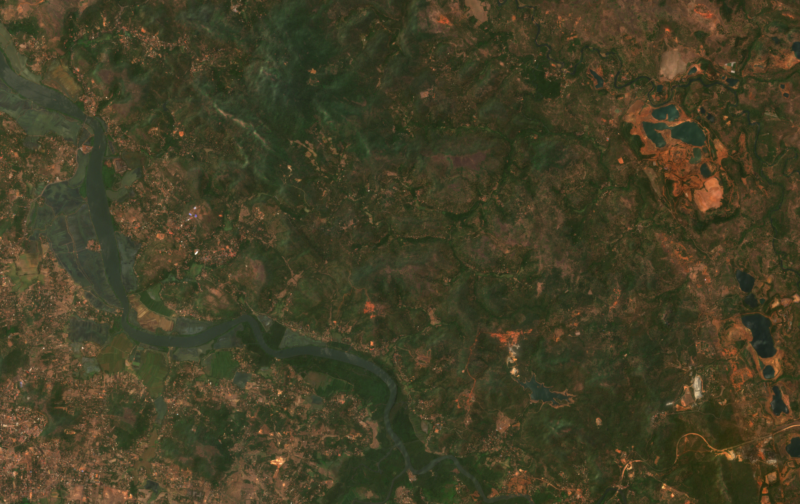

In [67]:
### Example of North Goa

with rasterio.open('ktaka_images/North Goa/2021-03-20/S2A_MSIL2A_20210320T052651_R105_T43PCS_20210320T190457.cropped.tif') as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)
    img = PILImage.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
    w = img.size[0]
    h = img.size[1]
    aspect = w / h
    target_w = 800
    target_h = (int)(target_w / aspect)
    img.resize((target_w, target_h), PILImage.Resampling.BILINEAR)

In [50]:
!split -b 50m './ktaka20' 'ktaka20.tar.gz.part.'

In [ ]:
ktaka.